<a href="https://colab.research.google.com/github/aleksandrkaplun/AmazonStockPredict/blob/main/AmazonStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler




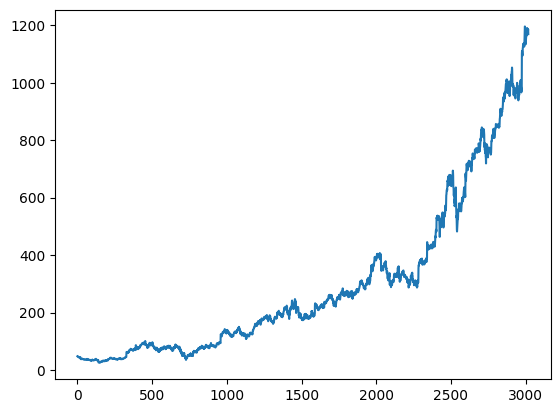

In [2]:
#Read dataset and plotting amazon stock prices
data = pd.read_csv('AMZN_2006-01-01_to_2018-01-01.csv')
data.head()
plt.plot(data[['Close']])

In [3]:
price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

<ipython-input-3-fa848fa03d6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [4]:
def split_data(stock, lookback):
  data_raw = stock.to_numpy() # convert to numpy array
  data = []
  # create all possible sequences of length seq_len
  for index in range(len(data_raw) - lookback):
   data.append(data_raw[index: index + lookback])
  data = np.array(data);
  test_set_size = int(np.round(0.2*data.shape[0]));
  train_set_size = data.shape[0] - (test_set_size);
  x_train = data[:train_set_size,:-1,:]
  y_train = data[:train_set_size,-1,:]
  x_test = data[train_set_size:,:-1]
  y_test = data[train_set_size:,-1,:]
  return [x_train, y_train, x_test, y_test]
lookback = 10 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [13]:

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

TypeError: expected np.ndarray (got Tensor)

In [14]:
# set parametrs
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [7]:
class LSTM(nn.Module):
   def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
   def forward(self, x):
     h0 = torch.zeros(self.num_layers, x.size(0),
     self.hidden_dim).requires_grad_()
     c0 = torch.zeros(self.num_layers, x.size(0),
     self.hidden_dim).requires_grad_()
     out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
     out = self.fc(out[:, -1, :])
     return out

In [8]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim,
output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
   y_train_pred = model(x_train)
   loss = criterion(y_train_pred, y_train_lstm)
   print("Epoch ", t, "MSE: ", loss.item())
   hist[t] = loss.item()
   optimiser.zero_grad()
   loss.backward()
   optimiser.step()
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.31887102127075195
Epoch  1 MSE:  0.18240021169185638
Epoch  2 MSE:  0.07359597086906433
Epoch  3 MSE:  0.04506872594356537
Epoch  4 MSE:  0.08014322817325592
Epoch  5 MSE:  0.04423438385128975
Epoch  6 MSE:  0.034213412553071976
Epoch  7 MSE:  0.04279409721493721
Epoch  8 MSE:  0.04997475445270538
Epoch  9 MSE:  0.05008243769407272
Epoch  10 MSE:  0.044780220836400986
Epoch  11 MSE:  0.03785248473286629
Epoch  12 MSE:  0.03314775601029396
Epoch  13 MSE:  0.03293933719396591
Epoch  14 MSE:  0.03618716448545456
Epoch  15 MSE:  0.038878146559000015
Epoch  16 MSE:  0.037943560630083084
Epoch  17 MSE:  0.03423905745148659
Epoch  18 MSE:  0.030717983841896057
Epoch  19 MSE:  0.029241137206554413
Epoch  20 MSE:  0.029597412794828415
Epoch  21 MSE:  0.030407298356294632
Epoch  22 MSE:  0.030317086726427078
Epoch  23 MSE:  0.028708064928650856
Epoch  24 MSE:  0.025907136499881744
Epoch  25 MSE:  0.02301771193742752
Epoch  26 MSE:  0.021295851096510887
Epoch  27 MSE:  0.02095163

In [10]:

predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))
y_test_pred = model(x_test)

test_predict = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().numpy()))
test_original = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().numpy()))

test_predict.values
test_original.values

np.max(np.abs(test_predict.values-test_original.values))

0.0

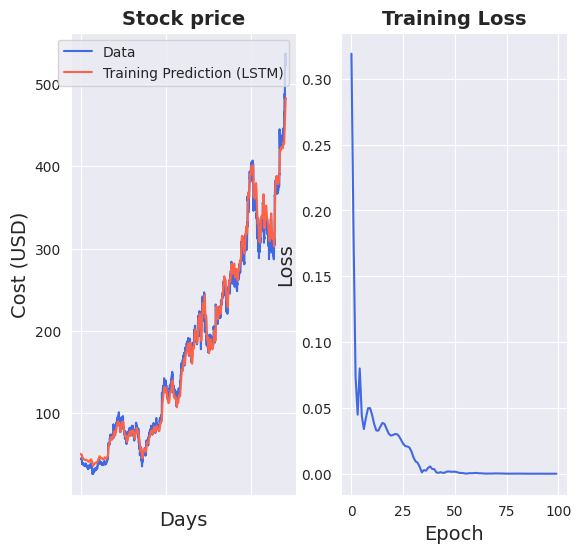

In [11]:
sns.set_style("darkgrid")
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0],
label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0],
label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)